#### EngLyser Research
##### Pushkar Sheth | http://phsheth.github.io

In [1]:
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.signal import butter, lfilter
import scipy as sp
import matplotlib.pyplot as plt
from pylab import *

from time import perf_counter
import pandas as pd

from sklearn.cross_validation import train_test_split

from sklearn.ensemble import RandomForestClassifier


%matplotlib qt

C:\Users\phs\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def thetagen(cycles,thetastepsize, forwardoffset):
    thetasingle = np.array(np.arange(0,720,thetastepsize))
    thetarel = np.tile(thetasingle,cycles)
    #thetacum = np.cumsum(thetarel)
    thetacum = np.array(np.arange(0,(720*cycles),thetastepsize))
    #thetacum = thetacum
    return thetasingle, thetarel, thetacum

In [3]:
def gasforcegen(gasforceraw, cycles, thetastepsize,forwardoffset,misfiring):
    thetasingle_deg, thetarel_deg, thetacum_deg = thetagen(cycles,thetastepsize,forwardoffset)
    gasforcerawdata = pd.read_csv(gasforceraw,sep=',',header=None)
    funcakimainterp_gf = sp.interpolate.Akima1DInterpolator(gasforcerawdata[0],gasforcerawdata[1])
    gasforce_theta_deg = funcakimainterp_gf(thetasingle_deg)
    gasforce_theta_deg_cycles = np.tile(gasforce_theta_deg,cycles)
    gasforce_theta_deg_cycles = gasforce_theta_deg_cycles*misfiring
    return gasforce_theta_deg_cycles, thetarel_deg,thetacum_deg

In [4]:
def torquegen(l1_m, l2_m,
              mrod, Izz, lg, mp, engine_speed_rpm, rp_m, 
              gasforcefile, cycles, thetastepsize,forwardoffset,misfiring):
    gasforce_theta_deg_cycles, thetarel_deg,thetacum_deg = gasforcegen(gasforcefile, cycles, thetastepsize,forwardoffset,misfiring)
    #gasforce_theta_deg_cycles = 35*gasforce_theta_deg_cycles/max(gasforce_theta_deg_cycles)
    thetacum_rad = thetacum_deg*np.pi/180
    theta_d = engine_speed_rpm*2*np.pi/60
    theta_dd = 0
    beta = np.arcsin(l1_m*np.sin(thetacum_rad)/l2_m)
    con1 = (1-(np.square(l1_m*np.sin(thetacum_rad)/l2_m)))
    beta_d = (theta_d*l1_m*np.cos(thetacum_rad))/(l2_m*np.sqrt(con1))
    
    a_beta_dd = l1_m*((theta_dd*np.cos(thetacum_rad))-((np.square(theta_d))*np.sin(thetacum_rad)))
    b_beta_dd = l2_m*np.sqrt(con1)
    c_beta_dd = np.square(theta_d)*np.power(l1_m,3)*np.square(np.cos(thetacum_rad))*np.sin(thetacum_rad)
    d_beta_dd = np.power(l2_m,3)*con1
    beta_dd= (a_beta_dd/b_beta_dd)+(c_beta_dd/d_beta_dd)

    a_vpis = (l1_m*theta_d*np.sin(thetacum_rad))
    b_vpis = (np.square(l1_m)*theta_d*np.sin(2*thetacum_rad))
    c_vpis = 2*l2_m*np.sqrt(con1)
    vpis = -a_vpis-(b_vpis/c_vpis)
    
    a_arx = l1_m*theta_dd*np.sin(thetacum_rad)
    b_arx = l1_m*(np.square(theta_d))*np.cos(thetacum_rad)
    c_arx = theta_dd*lg*np.square(l1_m)*np.sin(2*thetacum_rad)
    d_arx = 2*np.square(l2_m)*np.sqrt(con1)
    e_arx = np.square(l2_m)*(2*con1)
    f_arx = np.square(theta_d*l1_m)*lg
    g_arx = 2*np.cos(2*thetacum_rad)*np.sqrt(con1)
    h_arx = np.square(l1_m*np.sin(2*thetacum_rad))
    i_arx = 2*np.square(l2_m)*np.sqrt(con1)
    arx = -a_arx-b_arx-(c_arx/d_arx)-(1/e_arx)*f_arx*(g_arx+(h_arx/i_arx))
    
    a_ary = l1_m*theta_dd*np.cos(thetacum_rad)
    b_ary = l1_m*np.square(theta_d)*np.sin(thetacum_rad)
    c_ary = lg*l1_m*theta_dd*np.cos(thetacum_rad)/l2_m
    d_ary = lg*l1_m*theta_d*np.sin(thetacum_rad)/l2_m
    ary = a_ary - b_ary - c_ary+d_ary
    
    a_apx = l1_m*theta_dd*np.sin(thetacum_rad)
    b_apx = l1_m*(np.square(theta_d))*np.cos(thetacum_rad)
    c_apx = theta_dd*np.square(l1_m)*np.sin(2*thetacum_rad)
    d_apx = 2*l2_m*np.sqrt(con1)
    e_apx = l2_m*(2*con1)
    f_apx = np.square(theta_d*l1_m)
    g_apx = 2*np.cos(2*thetacum_rad)*np.sqrt(con1)
    h_apx = np.square(l1_m*np.sin(2*thetacum_rad))
    i_apx = 2*np.square(l2_m)*np.sqrt(con1)
    apx = -a_apx-b_apx-(c_apx/d_apx)-(1/e_apx)*f_apx*(g_apx+(h_apx/i_apx))
    
    fpx = (mp*apx)+((np.pi)*np.square(rp_m)*gasforce_theta_deg_cycles*0.1*1000000/4)
    
    fax = mrod*arx+fpx
    fay = (1/l2_m)*(((Izz*beta_dd-(fax*lg-fpx*(l2_m-lg)*np.sin(beta)))/np.cos(beta))+mrod*ary*(l2_m-lg))
    
    fx = fax*np.cos(thetacum_rad)+fay*np.sin(thetacum_rad)
    fy = fay*np.cos(thetacum_rad)-fax*np.sin(thetacum_rad)
    #forwardoffset = forwardoffset*np.pi/180
    #thetacum_rad = thetacum_rad
    rpm2radpersec = 6*sp.pi/180
    omega1_radpsec = engine_speed_rpm*rpm2radpersec
    time = thetacum_rad/omega1_radpsec
    torque = -fy*l1_m*1000
    forwardoffset_rad = forwardoffset*np.pi/180
    time_offset = forwardoffset_rad/omega1_radpsec
    offsetindex = (np.where(time == time_offset))
    torque = np.roll(torque,offsetindex[0][0])
    return torque, time, thetacum_deg

In [5]:
fy_1, time_1, theta_1 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,0,1)
fy_5, time_5, theta_5 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,90,1)
fy_4, time_4, theta_4 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,180,1)
fy_8, time_8, theta_8 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,270,1)
fy_6, time_6, theta_6 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,360,1)
fy_3, time_3, theta_3 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,450,1)
fy_7, time_7, theta_7 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,540,1)
fy_2, time_2, theta_2 = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,630,1)

In [6]:
fy_1 = fy_1 + np.random.normal(0,((((max(fy_1))-(min(fy_1)))/2))*0.01,len(fy_1))
fy_5 = fy_5 + np.random.normal(0,((((max(fy_5))-(min(fy_5)))/2))*0.01,len(fy_5))
fy_4 = fy_4 + np.random.normal(0,((((max(fy_4))-(min(fy_4)))/2))*0.01,len(fy_4))
fy_8 = fy_8 + np.random.normal(0,((((max(fy_8))-(min(fy_8)))/2))*0.01,len(fy_8))
fy_6 = fy_6 + np.random.normal(0,((((max(fy_6))-(min(fy_6)))/2))*0.01,len(fy_6))
fy_3 = fy_3 + np.random.normal(0,((((max(fy_3))-(min(fy_3)))/2))*0.01,len(fy_3))
fy_7 = fy_7 + np.random.normal(0,((((max(fy_7))-(min(fy_7)))/2))*0.01,len(fy_7))
fy_2 = fy_2 + np.random.normal(0,((((max(fy_2))-(min(fy_2)))/2))*0.01,len(fy_2))

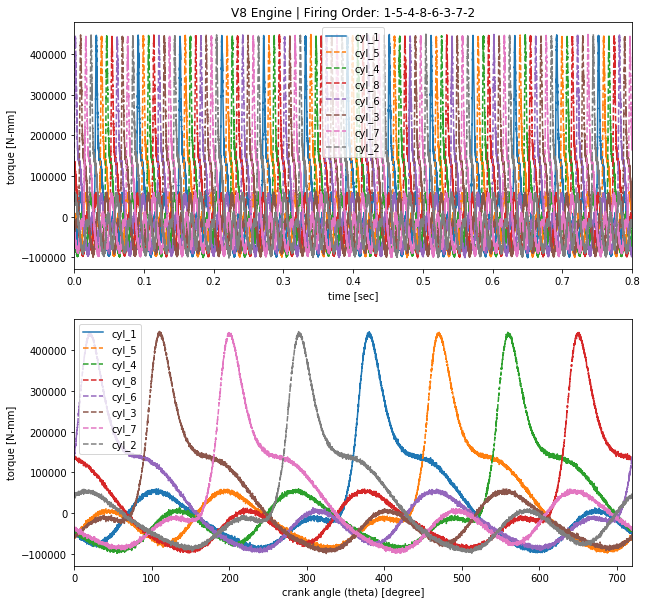

In [7]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.subplot(2,1,1)

plt.plot(time_1,fy_1,label='cyl_1')
plt.plot(time_1,fy_5,"--",label='cyl_5')
plt.plot(time_1,fy_4,"--",label='cyl_4')
plt.plot(time_1,fy_8,"--",label='cyl_8')
plt.plot(time_1,fy_6,"--",label='cyl_6')
plt.plot(time_1,fy_3,"--",label='cyl_3')
plt.plot(time_1,fy_7,"--",label='cyl_7')
plt.plot(time_1,fy_2,"--",label='cyl_2')
plt.legend()
plt.xlabel("time [sec]")
plt.ylabel("torque [N-mm]")
plt.xlim(0,0.8)
plt.title("V8 Engine | Firing Order: 1-5-4-8-6-3-7-2")

plt.subplot(2,1,2)
plt.plot(theta_1,fy_1,label='cyl_1')
plt.plot(theta_1,fy_5,"--",label='cyl_5')
plt.plot(theta_1,fy_4,"--",label='cyl_4')
plt.plot(theta_1,fy_8,"--",label='cyl_8')
plt.plot(theta_1,fy_6,"--",label='cyl_6')
plt.plot(theta_1,fy_3,"--",label='cyl_3')
plt.plot(theta_1,fy_7,"--",label='cyl_7')
plt.plot(theta_1,fy_2,"--",label='cyl_2')
plt.legend(loc = 'upper left')
plt.xlim(0,720)
plt.xlabel("crank angle (theta) [degree]")
plt.ylabel("torque [N-mm]")


plt.show()

In [8]:
torque_cylnom = fy_1+fy_5+fy_4+fy_8+fy_6+fy_3+fy_7+fy_2

In [9]:

#Vectorised Code
def eval_freqfft_vect(time_sec, vibr):
    datalength_fft = len(time_sec)
    datalengthby2 = int(datalength_fft/2)
    timeavgcalc = np.array([], dtype = float64)
    time_sec_i = time_sec[1:]
    time_sec_i_1 = time_sec[:-1]
    timeavgcalc = time_sec_i - time_sec_i_1
    sigint_avg = np.mean(timeavgcalc)
    siginf = 1/(datalength_fft*sigint_avg)
    freqhztemp = np.arange(0,datalength_fft,dtype = float64)
    freqhz = freqhztemp*siginf
    freqhz = freqhz[0:datalengthby2]
    vibr_fft = np.abs(fft(vibr,axis = -1))
    vibr_fft = ((vibr_fft[0:datalengthby2])/datalength_fft)*2
    return freqhz,vibr_fft

In [10]:
fy_1_mf, time_1_mf, theta_1_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,0,0.1)
fy_5_mf, time_5_mf, theta_5_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,90,0.1)
fy_4_mf, time_4_mf, theta_4_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,180,0.1)
fy_8_mf, time_8_mf, theta_8_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,270,0.1)
fy_6_mf, time_6_mf, theta_6_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,360,0.1)
fy_3_mf, time_3_mf, theta_3_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,450,0.1)
fy_7_mf, time_7_mf, theta_7_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,540,0.1)
fy_2_mf, time_2_mf, theta_2_mf = torquegen(float(60/1000), float(140/1000),
                 float(0.6833038489), float( 1e-9), float(40/1000), float(0.3282204182), float(2000), float(0.080),
                 'gaspressures.dat', 20, 0.1,630,0.1)

In [11]:
fy_1_mf = fy_1_mf + np.random.normal(0,((((max(fy_1_mf))-(min(fy_1_mf)))/2))*0.01,len(fy_1_mf))
fy_5_mf = fy_5_mf + np.random.normal(0,((((max(fy_5_mf))-(min(fy_5_mf)))/2))*0.01,len(fy_5_mf))
fy_4_mf = fy_4_mf + np.random.normal(0,((((max(fy_4_mf))-(min(fy_4_mf)))/2))*0.01,len(fy_4_mf))
fy_8_mf = fy_8_mf + np.random.normal(0,((((max(fy_8_mf))-(min(fy_8_mf)))/2))*0.01,len(fy_8_mf))
fy_6_mf = fy_6_mf + np.random.normal(0,((((max(fy_6_mf))-(min(fy_6_mf)))/2))*0.01,len(fy_6_mf))
fy_3_mf = fy_3_mf + np.random.normal(0,((((max(fy_3_mf))-(min(fy_3_mf)))/2))*0.01,len(fy_3_mf))
fy_7_mf = fy_7_mf + np.random.normal(0,((((max(fy_7_mf))-(min(fy_7_mf)))/2))*0.01,len(fy_7_mf))
fy_2_mf = fy_2_mf + np.random.normal(0,((((max(fy_2_mf))-(min(fy_2_mf)))/2))*0.01,len(fy_2_mf))

In [12]:
torque_cyl1mf = fy_1_mf+fy_5   +fy_4   +fy_8   +fy_6   +fy_3   +fy_7   +fy_2
torque_cyl5mf = fy_1   +fy_5_mf+fy_4   +fy_8   +fy_6   +fy_3   +fy_7   +fy_2
torque_cyl4mf = fy_1   +fy_5   +fy_4_mf+fy_8   +fy_6   +fy_3   +fy_7   +fy_2
torque_cyl8mf = fy_1   +fy_5   +fy_4   +fy_8_mf+fy_6   +fy_3   +fy_7   +fy_2
torque_cyl6mf = fy_1   +fy_5   +fy_4   +fy_8   +fy_6_mf+fy_3   +fy_7   +fy_2
torque_cyl3mf = fy_1   +fy_5   +fy_4   +fy_8   +fy_6   +fy_3_mf+fy_7   +fy_2
torque_cyl7mf = fy_1   +fy_5   +fy_4   +fy_8   +fy_6   +fy_3   +fy_7_mf+fy_2
torque_cyl2mf = fy_1   +fy_5   +fy_4   +fy_8   +fy_6   +fy_3   +fy_7   +fy_2_mf

torque_cyl1234mf = fy_1_mf+fy_5   +fy_4_mf+fy_8   +fy_6   +fy_3_mf+fy_7   +fy_2_mf
torque_cyl5678mf = fy_1   +fy_5_mf+fy_4   +fy_8_mf+fy_6_mf+fy_3   +fy_7_mf+fy_2

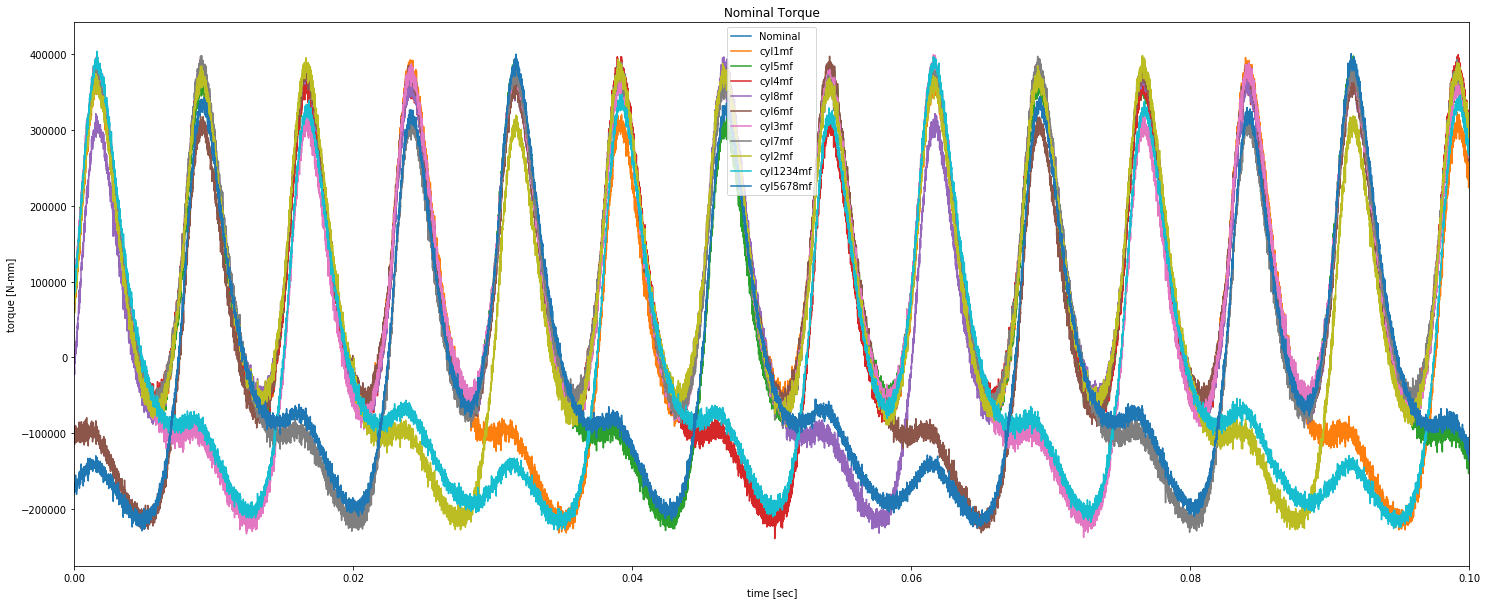

In [13]:
plt.rcParams['figure.figsize'] = [25, 10]

plt.plot(time_1,torque_cylnom, label ="Nominal")
plt.plot(time_1,torque_cyl1mf, label ="cyl1mf")
plt.plot(time_1,torque_cyl5mf, label ="cyl5mf")
plt.plot(time_1,torque_cyl4mf, label ="cyl4mf")
plt.plot(time_1,torque_cyl8mf, label ="cyl8mf")
plt.plot(time_1,torque_cyl6mf, label ="cyl6mf")
plt.plot(time_1,torque_cyl3mf, label ="cyl3mf")
plt.plot(time_1,torque_cyl7mf, label ="cyl7mf")
plt.plot(time_1,torque_cyl2mf, label ="cyl2mf")
plt.plot(time_1,torque_cyl1234mf, label ="cyl1234mf")
plt.plot(time_1,torque_cyl5678mf, label ="cyl5678mf")
plt.xlim(0,0.1)
plt.xlabel("time [sec]")
plt.ylabel("torque [N-mm]")
plt.title("Nominal Torque")
plt.legend()
plt.show()

In [14]:
freq_cylnom,vibr_cylnom = eval_freqfft_vect(time_1,torque_cylnom)
freq_cyl1mf,vibr_cyl1mf = eval_freqfft_vect(time_1,torque_cyl1mf)
freq_cyl5mf,vibr_cyl5mf = eval_freqfft_vect(time_1,torque_cyl5mf)
freq_cyl4mf,vibr_cyl4mf = eval_freqfft_vect(time_1,torque_cyl4mf)
freq_cyl8mf,vibr_cyl8mf = eval_freqfft_vect(time_1,torque_cyl8mf)
freq_cyl6mf,vibr_cyl6mf = eval_freqfft_vect(time_1,torque_cyl6mf)
freq_cyl3mf,vibr_cyl3mf = eval_freqfft_vect(time_1,torque_cyl3mf)
freq_cyl7mf,vibr_cyl7mf = eval_freqfft_vect(time_1,torque_cyl7mf)
freq_cyl2mf,vibr_cyl2mf = eval_freqfft_vect(time_1,torque_cyl2mf)
freq_cyl1234mf,vibr_cyl1234mf = eval_freqfft_vect(time_1,torque_cyl1234mf)
freq_cyl5678mf,vibr_cyl5678mf = eval_freqfft_vect(time_1,torque_cyl5678mf)



C:\Users\phs\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2966: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


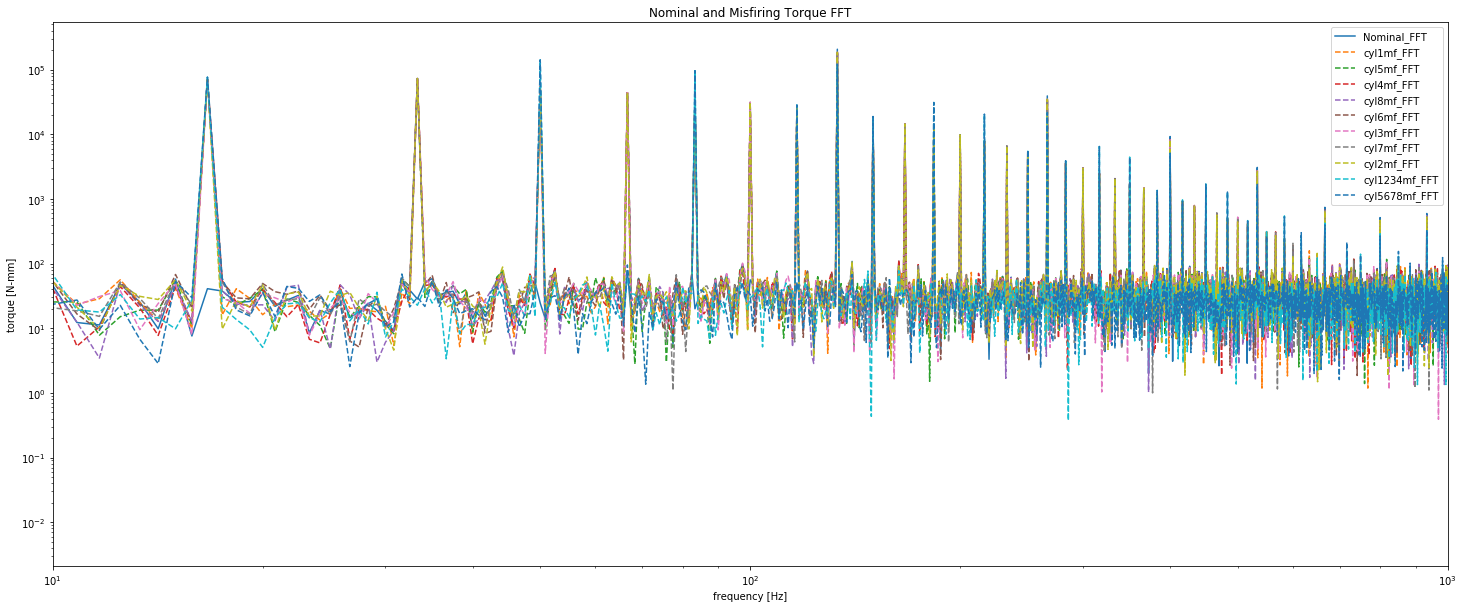

In [15]:
plt.rcParams['figure.figsize'] = [25, 10]

plt.loglog(freq_cylnom,vibr_cylnom, label ="Nominal_FFT")
plt.loglog(freq_cyl1mf,vibr_cyl1mf, "--", label ="cyl1mf_FFT")
plt.loglog(freq_cyl5mf,vibr_cyl5mf, "--", label ="cyl5mf_FFT")
plt.loglog(freq_cyl4mf,vibr_cyl4mf, "--", label ="cyl4mf_FFT")
plt.loglog(freq_cyl8mf,vibr_cyl8mf, "--", label ="cyl8mf_FFT")
plt.loglog(freq_cyl6mf,vibr_cyl6mf, "--", label ="cyl6mf_FFT")
plt.loglog(freq_cyl3mf,vibr_cyl3mf, "--", label ="cyl3mf_FFT")
plt.loglog(freq_cyl7mf,vibr_cyl7mf, "--", label ="cyl7mf_FFT")
plt.loglog(freq_cyl2mf,vibr_cyl2mf, "--", label ="cyl2mf_FFT")
plt.loglog(freq_cyl1234mf,vibr_cyl1234mf, "--", label ="cyl1234mf_FFT")
plt.loglog(freq_cyl5678mf,vibr_cyl5678mf, "--", label ="cyl5678mf_FFT")
plt.xlim(0,0.1)
plt.xlabel("frequency [Hz]")
plt.ylabel("torque [N-mm]")
plt.title("Nominal and Misfiring Torque FFT")
plt.xlim(10,1000)
plt.legend()
plt.show()

In [16]:
x = np.block([[vibr_cylnom],
              [vibr_cyl1mf],
              [vibr_cyl5mf],
              [vibr_cyl4mf],
              [vibr_cyl8mf],
              [vibr_cyl6mf],
              [vibr_cyl3mf],
              [vibr_cyl7mf],
              [vibr_cyl2mf],
              [vibr_cyl1234mf],
              [vibr_cyl5678mf]])
x

array([[2.23229150e+05, 6.12002284e+01, 2.28437659e+01, ...,
        4.49302187e+01, 4.64298183e+01, 4.01161155e+01],
       [1.55997855e+05, 5.21412344e+01, 2.81817250e+01, ...,
        4.94327056e+01, 4.99631351e+01, 2.31265487e+01],
       [1.56058110e+05, 6.60657040e+01, 1.89090182e+01, ...,
        3.20385246e+01, 4.18521202e+01, 3.39998305e+01],
       ...,
       [1.56008570e+05, 5.50256245e+01, 2.45447655e+01, ...,
        3.80493406e+01, 5.04036722e+01, 2.13617265e+01],
       [4.56256338e+04, 2.78845091e+01, 2.29006938e+01, ...,
        3.71214166e+01, 5.02060588e+01, 1.87263946e+01],
       [4.55346522e+04, 3.92984994e+01, 3.67444575e+01, ...,
        1.95372294e+01, 2.32015139e+01, 4.15733169e+01]])

In [17]:
y = np.array([[0,0,0,0,0,0,0,0],
            [1,0,0,0,0,0,0,0],
            [0,1,0,0,0,0,0,0],
            [0,0,1,0,0,0,0,0],
            [0,0,0,1,0,0,0,0],
            [0,0,0,0,1,0,0,0],
            [0,0,0,0,0,1,0,0],
            [0,0,0,0,0,0,1,0],
            [0,0,0,0,0,0,0,1],
            [1,0,1,0,0,1,0,1],
            [0,1,0,1,1,0,1,0]], dtype = float)
y 

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 0., 1.],
       [0., 1., 0., 1., 1., 0., 1., 0.]])

In [18]:
dataframe_np = np.block([x,y])
dataframe_np

array([[2.23229150e+05, 6.12002284e+01, 2.28437659e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.55997855e+05, 5.21412344e+01, 2.81817250e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.56058110e+05, 6.60657040e+01, 1.89090182e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.56008570e+05, 5.50256245e+01, 2.45447655e+01, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.56256338e+04, 2.78845091e+01, 2.29006938e+01, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.55346522e+04, 3.92984994e+01, 3.67444575e+01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [19]:
v8_df = pd.DataFrame(dataframe_np)

In [20]:
v8_df

0          1          2          3          4           5      \
0   223229.149555  61.200228  22.843766  23.920297  62.738477  109.686824   
1   155997.855098  52.141234  28.181725  19.654092  46.961842   80.799084   
2   156058.109658  66.065704  18.909018  29.170089  63.987151  116.102575   
3   156025.571834  53.142355  18.010751  31.310559  50.713636  101.073353   
4   156032.268499  57.699765  44.828960   4.612150  56.831293   98.228557   
5   156028.944302  43.107271  39.248816  29.031762  47.327469   91.519508   
6   156029.818283  48.697911  18.272715  20.724673  57.444950   93.385735   
7   156033.473999  56.375829  10.833519  30.348364  54.937975   96.095922   
8   156008.569637  55.025625  24.544765  24.376212  67.692657   97.055161   
9    45625.633812  27.884509  22.900694  25.420662  35.178268   43.316653   
10   45534.652205  39.298499  36.744458  21.727611  33.749282   72.837333   

        6          7          8          9      ...        71998      71999  \
0   45.192908  28.258543  16.484656  29.524327  ...    46.429818  40.116116   
1   50.360674  24.668614  25.300314  35.957616  ...    49.963135  23.126549   
2   38.413848  33.098343  18.575453  32.867571  ...    41.852120  33.999830   
3   51.995641  27.432868  30.621718  24.863026  ...    50.199650  38.024928   
4   31.836805  29.644011  13.373779  20.483208  ...    27.923879  34.604661   
5   45.989217  33.420391  21.181104  22.831121  ...    33.872732  46.399306   
6    8.523475  25.626666  19.791032  30.066424  ...    40.334553  46.118816   
7   24.293993  21.375185  19.235461  25.022229  ...    40.631676  48.110909   
8   59.147854  24.142401  18.114036  37.243654  ...    50.403672  21.361727   
9   33.962794   8.830484  17.552010  36.303876  ...    50.206059  18.726395   
10   4.264415  32.243661  10.633424  19.291337  ...    23.201514  41.573317   

    72000  72001  72002  72003  72004  72005  72006  72007  
0     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1     1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2     0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0  
3     0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0  
4     0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0  
5     0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0  
6     0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0  
7     0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0  
8     0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0  
9     1.0    0.0    1.0    0.0    0.0    1.0    0.0    1.0  
10    0.0    1.0    0.0    1.0    1.0    0.0    1.0    0.0  

[11 rows x 72008 columns]

In [21]:
x,y

(array([[2.23229150e+05, 6.12002284e+01, 2.28437659e+01, ...,
         4.49302187e+01, 4.64298183e+01, 4.01161155e+01],
        [1.55997855e+05, 5.21412344e+01, 2.81817250e+01, ...,
         4.94327056e+01, 4.99631351e+01, 2.31265487e+01],
        [1.56058110e+05, 6.60657040e+01, 1.89090182e+01, ...,
         3.20385246e+01, 4.18521202e+01, 3.39998305e+01],
        ...,
        [1.56008570e+05, 5.50256245e+01, 2.45447655e+01, ...,
         3.80493406e+01, 5.04036722e+01, 2.13617265e+01],
        [4.56256338e+04, 2.78845091e+01, 2.29006938e+01, ...,
         3.71214166e+01, 5.02060588e+01, 1.87263946e+01],
        [4.55346522e+04, 3.92984994e+01, 3.67444575e+01, ...,
         1.95372294e+01, 2.32015139e+01, 4.15733169e+01]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state=0)
#x_train = np.reshape(x_train, (-1,1))
#x_test = np.reshape(x_test, (-1,1))
#y_train = np.reshape(y_train, (-1,1))
#y_test = np.reshape(y_test, (-1,1))

In [23]:
np.shape(x_train), np.shape(y_train)

((9, 72000), (9, 8))

In [24]:
np.shape(x_test), np.shape(y_test )

((2, 72000), (2, 8))

In [25]:
from sklearn.svm import SVC
classifier = RandomForestClassifier(n_jobs=2, random_state = 0 )
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [26]:
y_pred = classifier.predict(x_test)

In [27]:
y_pred,y_test

(array([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 1.]]))